In [1]:
import os
import gc
import time
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F

#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

epochs = 10
batch_size = 4
learning_rate = 0.01
workers = 4 # The number of parallel processes used to read data
gpu_id = [0,1,2,3] # only modify if you machine has more than one GPU card

In [2]:
torch.cuda.device_count()

4

### Dataset [10 points]
We are going to use the [PASCAL VOC dataset](https://drive.google.com/drive/folders/1G54WDNnOQecr5T0sEvZcuyme0WT5Qje3?usp=sharing), which is a commonly used benchmark. In order to reduce the
computational requirements, you should downsample the dataset to 256x256, similar to the previous project.

# Part 2

## Semantic Segmentation

In this part of the project, you will reuse the model you created in the previous part to perform Semantic Segmentation - instead of assigning a real number to each
pixel , you will assign it a class.

The tasks are as following:
- Write a Dataset class that processes the segmentation data. **[10 points]**
    - Modify the UNet model that takes an RGB image and now outputs a single channel _label map_
    - Define an approprate loss function. **[5 points]**
- Tune the model to achieve an mIOU of **0.45** or higher on the given validation set. **[20 points]**

Now you have to implement the Dataset. Look at the file `loaders.py`.

The class you will need to emulate is `class ImageDepthDataset(Dataset)`. The class is called `VOCSeg`, and it must _inherit_ from the `Dataset` class,
just like the `ImageDepthDataset`.
You need to fill in the `__len__` and the `__getitem__` methods.
The `__getitem__` method should yield a dict of the RGB image and the labeled segmentation map.

Make sure you downsample the image and the labels to 256x256, otherwise the training will take too much time.

Make sure that the labels are in the range `0..N-1`, where
N is the number of classes - 21 in our case. You can have one special label for unknown regions.

We provide the map of RGB to label for convenience in `get_pascal_labels()`. The map should be read as this - if a pixel has color `[0, 0, 0]`, it has label 0. If the color is
`[128, 0, 0]`, the label is 1

It is also very common to change the RGB range from 0-255 to 0-1 or -1 to 1. Take a look at [torchvision.transforms.ToTensor](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.ToTensor)
and [torchvision.transforms.Normalize](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize)

The PASCAL VOC dataset has predefined train/val sets. Make sure your class implementation can take this _split_ as an argument. Now create train/val loaders using the `get_seg_loaders` function (look at `prep_loaders`), and we should be good to go.

In [2]:
%pylab inline
import torchvision
import torch

Populating the interactive namespace from numpy and matplotlib


In [3]:
import os
import glob
import torch
import numpy as np
from skimage import io, transform
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, random_split

np.random.seed(0) 
torch.manual_seed(0)
VALIDATION_SPLIT = 0.02

class DepthHalfSize(object):
    def __call__(self, sample):
        x = sample['depth']
        sample['depth'] = transform.resize(x, (x.shape[0]//2, x.shape[1]//2))
        return sample

class ToTensor(object):
    def __call__(self, sample):
        image, depth = sample['image'], sample['depth']
        # swap channel axis
        image = image.transpose((2, 0, 1))
        depth = depth.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image), 'depth': torch.from_numpy(depth)}
    
class DepthToNormal(object):
    def __call__(self, sample):
        dx, dy = np.gradient(sample['depth'].squeeze())
        dx, dy, dz = dx * 2500, dy * 2500, np.ones_like(dy)
        n = np.linalg.norm(np.stack((dy, dx, dz), axis=-1), axis=-1)
        d = np.stack((dy/n, dx/n, dz/n), axis=-1)
        return {'image': sample['image'], 'depth': (d + 1) * 0.5} 
        
class ImageDepthDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform 
        self.image_files = glob.glob(root_dir + '/*.jpg')
        
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = io.imread(self.image_files[idx]) / 255.0
        depth = io.imread(self.image_files[idx].replace('.jpg', '.png'))[:,:,:1] / 255.0        
        sample = {'image': image, 'depth': depth}        
        return self.transform(sample) if self.transform else sample
    
def prep_loaders(root_dir=None, batch_size=1, workers=1):
    # Load dataset
    image_depth_dataset = ImageDepthDataset(root_dir=root_dir, transform=transforms.Compose([DepthHalfSize(), ToTensor()]))

    # Split into training and validation sets
    train_size = int((1-VALIDATION_SPLIT) * len(image_depth_dataset))
    test_size = len(image_depth_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(image_depth_dataset, [train_size, test_size])

    # Prepare data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
    valid_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)
    print('Dataset size (num. batches)', len(train_loader), len(valid_loader))
    
    return train_loader, valid_loader

##############################################################
################# Segmentation Section #######################
##############################################################

class SegIdentityTransform(object):
    # Hint: Note that our transforms work on dicts. This is an example of a transform that works
    # on a dict whose elements can be converted to np.arrays, and are then converted to torch.tensors
    # This performs the scaling of the RGB by division by 255, and puts channels first by performing the permute
    # for the label, we convert to long, datatype to let torch know that this is a discrete label.
    # You might want to change this or write different transforms depending on how you read data.
    def __call__(self, sample):
        x = sample['image']
        sample['image'] = transform.resize(x, (256,256),preserve_range=True)
        y= sample['label']
        sample['label'] = transform.resize(y, (256,256),preserve_range=True)
        
        tf = transforms.Compose([transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])
        
        
        #sample['image'] = sample['image']/255.0
        #sample['image'] = tf(sample['image'])
        
        
        return {'image': torch.tensor(np.array(sample['image']/255.0)).permute(2,0,1),
        #return {'image': torch.tensor(np.array(sample['image']/255.0)),
                'label': torch.tensor(np.array(sample['label'])).long()}
        #return sample

def get_pascal_labels():
    """Load the mapping that associates pascal classes with label colors
    Returns:
        np.ndarray with dimensions (21, 3)
    """
    return np.asarray([[0, 0, 0],
                       [128, 0, 0],
                       [0, 128, 0],
                       [128, 128, 0],
                       [0, 0, 128],
                       [128, 0, 128],
                       [0, 128, 128],
                       [128, 128, 128],
                       [64, 0, 0],
                       [192, 0, 0],
                       [64, 128, 0],
                       [192, 128, 0],
                       [64, 0, 128],
                       [192, 0, 128],
                       [64, 128, 128],
                       [192, 128, 128],
                       [0, 64, 0],
                       [128, 64, 0],
                       [0, 192, 0],
                       [128, 192, 0],
                       [0, 64, 128]])




def encode_segmap(mask):
    """Encode segmentation label images as pascal classes
    Args:
        mask (np.ndarray): raw segmentation label image of dimension
          (M, N, 3), in which the Pascal classes are encoded as colours.
    Returns:
        (np.ndarray): class map with dimensions (M,N), where the value at
        a given location is the integer denoting the class index.
    """

    # TODO (hint: You might not need a lot of work here with some libraries, which already read in the image as a single channel label)
    # (hint: the said library does not return a np.ndarray object)
    label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
    if isinstance(mask, np.ndarray):
        # TODO
        mask = mask.astype(int)
        for i, label in enumerate(get_pascal_labels()):
            #print(mask.shape)
            #print(i)
            #print(np.where(np.all(mask == label, axis=-1)))
            label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = i
        label_mask = label_mask.astype(int)
    else:
        # TODO if the image is just single channel
        #  you might want to convert the single channel label to a np.ndarray
        pass
    return label_mask

def decode_segmap(label_mask, unk_label=255):
    """Decode segmentation label prediction as RGB images
    Args:
        mask (torch.tensor): class map with dimensions (B, M,N), where the value at
        a given location is the integer denoting the class index.
    Returns:
        (np.ndarray): colored image of shape (BM, BN, 3)
    """
    #mask[mask == unk_label] == 0
    #mask = mask.numpy()
    #cmap = get_pascal_labels()
    #cmap_exp = cmap[..., None]
    #colored = cmap[mask].squeeze()
    #grid = make_grid(torch.tensor(colored).permute(0, 3, 1, 2))
    #return np.permute(grid, (1, 2, 0))

    label_colours = get_pascal_labels()
    r = label_mask.copy()
    g = label_mask.copy()
    b = label_mask.copy()
    for ll in range(0, 21):
        r[label_mask == ll] = label_colours[ll, 0]
        g[label_mask == ll] = label_colours[ll, 1]
        b[label_mask == ll] = label_colours[ll, 2]
    rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
    print(rgb.shape)
    print(r.shape)
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    plt.imshow(rgb)
    plt.show()



class VOCSeg(Dataset):
    def __init__(self, root_dir, split=None, transform=None):
        # Known information
        self.num_classes = 21
        self.class_names = ['Background',
                            'Aeroplane',
                            'Bicycle',
                            'Bird',
                            'Boat',
                            'Bottle',
                            'Bus',
                            'Car',
                            'Cat',
                            'Chair',
                            'Cow',
                            'Diningtable',
                            'Dog',
                            'Horse',
                            'Motorbike',
                            'Person',
                            'Pottedplant',
                            'Sheep',
                            'Sofa',
                            'Train',
                            'Tvmonitor']

        # Set up proper paths
        self.root_dir = root_dir
        self.image_dir = os.path.join(self.root_dir, 'JPEGImages')
        self.label_dir = os.path.join(self.root_dir, 'SegmentationClass')
        
        self.transform = transform 

        #TODO Read the appropriate split file and save the file names
        self.split = split
        self.split_file_dir = os.path.join(self.root_dir, 'ImageSets', 'Segmentation')

        # TODO read in ONLY files from self.split_file
        #self.image_files = None
        #self.label_files = None
        with open(os.path.join(os.path.join(self.split_file_dir, self.split + '.txt')), "r") as f:
            lines = f.read().splitlines()
            self.image_files = [os.path.join(self.root_dir, "JPEGImages", name + ".jpg") for name in lines]
            self.label_files = [os.path.join(self.root_dir, "SegmentationClass", name + ".png") for name in lines]
            print(len(self.image_files))
            
        


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):

        # TODO Retrieve the saved file names and perform the proper processing
        # The images go from 0-255 to 0-1. You can also use the range -1 to 1
        # The labels go from a 3 channel RGB to a single channel with elements in the range 0..N-1
        #image = None
        image = io.imread(self.image_files[idx])
        #label_rgb = None
        label_rgb = io.imread(self.label_files[idx])
        label = label_rgb[:,:,:3]
        label = encode_segmap(label) # write the encode_segmap function
        sample = {'image': image, 'label': label}
        
        return self.transform(sample)


def get_seg_loaders(root_dir=None, batch_size=1, workers=1):

    #TODO optionally add more augmentation
    ####Please see function SegIdentityTransform 
    
    tfms = transforms.Compose([
        #transforms.Resize(256),
        #transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225]),
        SegIdentityTransform()
    ])

    train_set = VOCSeg(root_dir=root_dir, split='train', transform=tfms)
    val_set = VOCSeg(root_dir=root_dir, split='val', transform=tfms) # No transforms on the validation set

    # Prepare data_loaders
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=workers)
    valid_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=workers)

    return train_loader, valid_loader

if __name__ == '__main__':
    pass

In [4]:
# Sanity check

if __name__ == '__main__':
    #from loaders import get_seg_loaders
    train_loader, valid_loader = get_seg_loaders(root_dir='./VOC2012',batch_size=batch_size,workers=workers)

    # we have read all files
    assert len(train_loader.dataset) == 1464
    assert len(valid_loader.dataset) == 1449
    

1464
1449


tensor(20)
tensor(1., dtype=torch.float64)
torch.Size([4, 256, 256])
torch.Size([4, 3, 256, 256])
tensor([[[[0.1116, 0.1047, 0.1168,  ..., 0.3680, 0.3597, 0.3437],
          [0.0929, 0.0822, 0.0803,  ..., 0.3090, 0.2718, 0.2621],
          [0.0836, 0.0686, 0.0682,  ..., 0.2588, 0.2375, 0.2276],
          ...,
          [0.3387, 0.3392, 0.3392,  ..., 0.2560, 0.2534, 0.2539],
          [0.3399, 0.3429, 0.3438,  ..., 0.2536, 0.2478, 0.2488],
          [0.3339, 0.3359, 0.3393,  ..., 0.2491, 0.2437, 0.2437]],

         [[0.1252, 0.1240, 0.1397,  ..., 0.3503, 0.3325, 0.3300],
          [0.1049, 0.0963, 0.0946,  ..., 0.3023, 0.2815, 0.2807],
          [0.0920, 0.0753, 0.0761,  ..., 0.2593, 0.2305, 0.2327],
          ...,
          [0.3646, 0.3671, 0.3676,  ..., 0.2863, 0.2880, 0.2892],
          [0.3683, 0.3733, 0.3756,  ..., 0.2863, 0.2884, 0.2863],
          [0.3617, 0.3673, 0.3729,  ..., 0.2883, 0.2950, 0.2879]],

         [[0.0977, 0.0969, 0.1043,  ..., 0.3255, 0.3158, 0.3154],
          

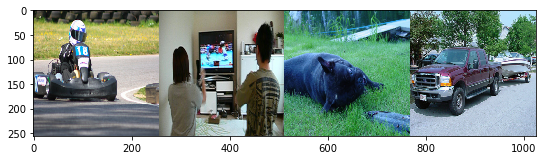

In [6]:
sample = iter(train_loader).next()
figure(figsize=(9,9)); imshow(torchvision.utils.make_grid(sample['image'], padding=0).permute((1, 2, 0)))
#figure(figsize=(9,9)); imshow(torchvision.utils.make_grid(sample['label'], padding=0).permute((1, 2, 0)))
label = sample['label']
image = sample['image']
print(label.max())
print(image.max())
print(label.shape)
print(image.shape)
print(image)
print(label)
    
    #print(image)

You should implement a few more sanity checks - the range of data in the RGB part, the range of data in the label part, whether the dataset returns tensors,
whether the labels have the datatype `torch.long` etc.

## Modifying the Loss and Architecture [5 points]
You will have to some form of surgery on the network you constructed in Part 1.

1. The number of channels the last layer predicts must change to the number of classes in the dataset.
2. The loss function must change to reflect the fact that we are now performing per-pixel classification. (What loss did you use for classification in Project 1?)
3. You might get a CUDA assert error. This means that you have a label higher than the number of channels in the _logits_. This is very common with semantic segmentation, where you might want to label some region unkown as it's label might be under doubt - for example near the edges of objects. Look up how to ignore a certain label with a classification loss.
4. Take care of input label and logit sizes. We want predictions to be 256x256 as well.

In [7]:
import torch
from math import exp
import torch.nn.functional as F
from torch.autograd import Variable




#### Cross Entropy
def loss_fn(y_pred, y):
    y_pred.requires_grad = True
    y_pred = torch.sigmoid(y_pred)
    loss = nn.CrossEntropyLoss(ignore_index=0)(y_pred, y)
    return loss

####Dice Loss
def loss_fn(y_pred, y):
    
    #y_pred = Variable(y_pred, requires_grad=True)
    #y_pred.requires_grad = True
    #print(y_pred.shape)
    y_pred = torch.sigmoid(y_pred)
    y_pred = torch.argmax(y_pred, dim=1)
    #y_pred = y_pred.argmax(1)
    #print(y_pred.shape)
    #bce = F.binary_cross_entropy_with_logits(y_pred, y)
    
    #pred = y_pred.view(-1)
    #y = y.view(-1)
    #y = torch.as_tensor(y)
    #y_pred = torch.as_tensor(y_pred)
    y = F.one_hot(y, num_classes = 21).contiguous().float()
    y_pred   = F.one_hot(y_pred, num_classes = 21).contiguous().float()
    
    #y = Variable(y.float(), requires_grad=True)
    #pred = Variable(pred.float(), requires_grad=True)
    #y.requires_grad = True
    y_pred.requires_grad = True
    
    #pred = pred.view(-1)
    #y = y.view(-1)
    y_pred = y_pred.squeeze(1)
    y = y.squeeze(1)
    
    
    smooth = 1.
    intersection = (y_pred * y).sum()
    loss =  1 - ((2. * intersection + smooth)/(y_pred.sum() + y.sum() + smooth))
    #print(loss)
    #return bce_loss(y_pred,y)
    #return bce
    return loss


In [8]:
class Up(nn.Module):

    def __init__(self, in_channels, out_channels, down):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        if(down==1):
            self.conv = Down(in_channels, out_channels,pooling=False)
        else:
            self.conv = Down2(in_channels, out_channels,pooling=False)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.shape[2] - x1.shape[2]
        diffX = x2.shape[3] - x1.shape[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2]) 

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [9]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels,pooling=True):
        super().__init__()
        self.pooling = pooling
        self.maxpool = nn.MaxPool2d(2)
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels,kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        if(self.pooling):
            return self.maxpool(self.double_conv(x))
        else:
            return self.double_conv(x)


In [10]:
class Down2(nn.Module):
    def __init__(self, in_channels, out_channels,pooling=True):
        super().__init__()
        self.pooling = pooling
        self.maxpool = nn.MaxPool2d(2)
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels,kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels,kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        if(self.pooling):
            return self.maxpool(self.double_conv(x))
        else:
            return self.double_conv(x)

In [11]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.down1 = Down(3,64,pooling=False)
        self.down2 = Down(64,128,pooling=True)
        self.down3 = Down2(128,256,pooling=True)
        self.down4 = Down2(256,512,pooling=True)
        self.down5 = Down2(512,1024,pooling=True)

        self.up1 = Up(1024,512,down=2)
        self.up2 = Up(512, 256,down=2)
        self.up3 = Up(256, 128,down=2)
        self.up4 = Up(128, 64,down=1)
        #self.maxpool = nn.MaxPool2d(2)
        self.conv = nn.Conv2d(64, 21, kernel_size=1)


    def forward(self, x):

        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.down5(x4)
        x = self.up1(x5,x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        #x = self.maxpool(x)
        x = self.conv(x)
        return x

### !! 
### <span style="color:red"> At this point, we highly recommend restarting your notebook for part 2 and beginning modifying/training the  model</span>

In [12]:
import os
import gc
import time
import datetime

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

epochs = 30
batch_size = 8
learning_rate = 0.0001
workers = 1 # The number of parallel processes used to read data
gpu_id = [0] # only modify if you machine has more than one GPU card

In [63]:
if __name__ == '__main__':
    #from loaders import get_seg_loaders
    train_loader, valid_loader = get_seg_loaders(root_dir='./VOC2012',batch_size=batch_size,workers=workers)

1464
1449


In [13]:
def create_model_gpu():
    model = Model()
    model = model.cuda()
    model = nn.DataParallel(model, device_ids=[g for g in gpu_id])
    return model

model = create_model_gpu()
print('Ready to train.')


#for param in model.parameters():
#    param.requires_grad = False

Ready to train.


## Training and Evaluation [18 points]
Tune the hyperparameters to get the maximum possible score on the PASCAL VOC challenge. 
And answer the following questions:
1. What is the relationship between the _size_ of the class and the IOU How would you quantify this relationship?
2. What is the relationship between the number of instances and the IOU? how many times a class exists in an image vs the IOU?
3. The segmentation dataset is small. Initialize the weights of the segmentation net with the weights of the trained depth network.
4. Which weights can you not transfer?
5. Fine tune (ie train with a lower learning rate) the model in 3 for the same number of epochs as the model with a random initialization (or ImageNet initialized weights)
6. What trend do you observe?


In [14]:
from utils import Metrics

In [81]:
run_id = 'seg_model_gpu{}_n{}_bs{}_lr{}'.format(gpu_id, epochs, batch_size, learning_rate); print('\n\nTraining', run_id)
save_path = run_id + '.pkl'

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

metrics = Metrics(train_loader.dataset.num_classes, train_loader.dataset.class_names)

# Used to keep track of statistics
class AverageMeter(object):
    def __init__(self):
        self.val = 0; self.avg = 0; self.sum = 0; self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

REPORTS_PER_EPOCH = 10
ITER_PER_EPOCH = len(train_loader)
ITER_PER_REPORT = ITER_PER_EPOCH//REPORTS_PER_EPOCH



for epoch in range(epochs):
    model.train()

    # Progress reporting
    batch_time = AverageMeter()
    losses = AverageMeter()
    N = len(train_loader)
    end = time.time()

    for i, (sample) in enumerate(train_loader):
        
       
        # Load a batch and send it to GPU
        x = sample['image'].float().cuda()
        #y = sample['label'].float().cuda()
        y = sample['label'].cuda()
        # Forward pass: compute predicted y by passing x to the model.
        
        y_pred = model(x)
        # Compute and print loss.
        
        loss = loss_fn(y_pred, y)

        # Record loss
        losses.update(loss.data.item(), x.size(0))

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model).
        optimizer.zero_grad()
        

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()

        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        eta = str(datetime.timedelta(seconds=int(batch_time.val*(N - i))))

        # Log training progress
        if i % ITER_PER_REPORT == 0:
            print('\nEpoch: [{0}][{1}/{2}]\t' 'Time {batch_time.val:.3f} ({batch_time.sum:.3f})\t' 'ETA {eta}\t'
             'Training Loss {loss.val:.4f} ({loss.avg:.4f})'.format(epoch, i, N, batch_time=batch_time, loss=losses, eta=eta))
        elif i % (ITER_PER_REPORT) == 0:
            print('.', end='')

        #break # useful for quick debugging
    torch.cuda.empty_cache(); del x, y; gc.collect()

    # Validation after each epoch
    model.eval()
    metrics.reset()
    for i, (sample) in enumerate(valid_loader):
        x, y = sample['image'].float().cuda(), sample['label'].numpy()
        with torch.no_grad():
            y_pred = model(x)
            y_pred = torch.argmax(y_pred, dim=1) # get the most likely prediction

        metrics.add_batch(y, y_pred.detach().cpu().numpy())
        print('_', end='')
    print('\nValidation stats ', metrics.get_table())


# Save model
torch.save(model.state_dict(), save_path)
print('\nTraining done. Model saved ({}).'.format(save_path))



Training seg_model_gpu[0]_n30_bs8_lr0.0001

Epoch: [0][0/183]	Time 1.320 (1.320)	ETA 0:04:01	Training Loss 0.7542 (0.7542)

Epoch: [0][18/183]	Time 0.750 (15.421)	ETA 0:02:03	Training Loss 0.7673 (0.7792)

Epoch: [0][36/183]	Time 0.770 (29.460)	ETA 0:01:53	Training Loss 0.7766 (0.7825)

Epoch: [0][54/183]	Time 0.793 (43.821)	ETA 0:01:42	Training Loss 0.8022 (0.7822)

Epoch: [0][72/183]	Time 0.795 (57.855)	ETA 0:01:28	Training Loss 0.7709 (0.7840)

Epoch: [0][90/183]	Time 0.797 (71.995)	ETA 0:01:14	Training Loss 0.7917 (0.7877)

Epoch: [0][108/183]	Time 0.811 (86.060)	ETA 0:01:00	Training Loss 0.8342 (0.7882)

Epoch: [0][126/183]	Time 0.780 (100.198)	ETA 0:00:44	Training Loss 0.7612 (0.7885)


KeyboardInterrupt: 

### Visualization  [2 points]
Use the `decode_segmap` function to visualize images and their segmentation. The images must be from the validation set.


In [15]:
sample = iter(valid_loader).next()

In [16]:
model = create_model_gpu()
model.load_state_dict(torch.load('seg_model_gpu[0, 1, 2, 3]_n100_bs16_lr0.001.pkl'))
model.eval() # set to evaluation mode

DataParallel(
  (module): Model(
    (down1): Down(
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (double_conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (down2): Down(
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (double_conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), st

In [17]:
x = sample['image'].float().cuda()
y_pred, y = model(x), sample['label'].numpy()

(256, 256, 3)
(256, 256)


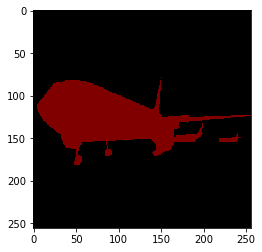

In [18]:
decode_segmap(y[0])

In [19]:
print(y_pred)

tensor([[[[-1.8232e+00, -7.4714e-01, -6.2621e-01,  ..., -1.2807e+00,
           -7.6362e-01, -3.7592e-01],
          [-1.9613e+00, -1.3405e+00, -2.9205e-01,  ..., -1.8845e-01,
           -1.1984e-01,  1.3256e-01],
          [-1.7386e+00, -6.8802e-01, -1.6121e-01,  ..., -2.0553e+00,
           -1.0061e+00, -1.8501e-01],
          ...,
          [-2.9698e-01,  4.4976e-03,  3.5449e-01,  ..., -5.6037e-01,
           -8.5167e-01,  6.5849e-01],
          [-2.3886e-01, -7.7414e-01, -2.3511e-01,  ..., -4.3090e-01,
           -1.8909e-02,  1.1475e+00],
          [ 3.6678e-02, -1.8029e-01, -2.2664e-01,  ..., -8.6593e-01,
           -3.6379e-01,  3.9941e-01]],

         [[-3.6874e-01, -7.2842e-02,  1.3164e-01,  ...,  3.4124e-01,
            1.0349e+00,  5.5677e-01],
          [-7.2954e-01, -9.1147e-01, -4.9053e-01,  ...,  2.7037e-01,
           -2.0213e-01,  7.0845e-02],
          [-3.4776e-01, -1.0992e-01, -1.2738e-01,  ..., -1.8107e-01,
           -6.8827e-01,  1.0697e+00],
          ...,
     

(256, 256, 3)
(256, 256)


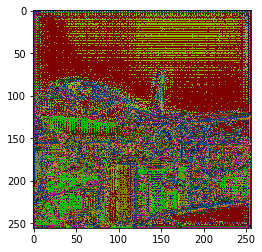

In [121]:
y_pred = torch.argmax(y_pred, dim=1)
y_pred = y_pred.cpu().detach().numpy()
decode_segmap(y_pred[0])